Saint Gall. 

In [ ]:
!git clone https://github.com/him4318/Transformer-ocr.git

Cloning into 'Transformer-ocr'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 96 (delta 38), reused 44 (delta 11), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [ ]:
%cd Transformer-ocr/

/content/Transformer-ocr


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.6 MB 16.7 MB/s 
     |████████████████████████████████| 28.2 MB 2.2 MB/s 
     |████████████████████████████████| 60 kB 9.0 MB/s 
     |████████████████████████████████| 752.0 MB 10 kB/s 
     |████████████████████████████████| 6.6 MB 25.5 MB/s 
     |████████████████████████████████| 20.2 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: torchvision
    Found existing installation: torchvi

In [ ]:
%cd src/

/content/Transformer-ocr/src


In [ ]:
!ls

data  engine.py  main.py  network


### 1.3 HDF5 files

Now, you'll run the *transform* function from **main.py**. For this, execute on **src** folder:

> ```python main.py --source=<DATASET_NAME> --transform```

Your data will be preprocess and encode, creating and saving in the **data** folder. Now your project directory will be like this:


```
.
├── data
│   ├── bentham.hdf5
│   ├── iam.hdf5
│   ├── rimes.hdf5
│   ├── saintgall.hdf5
│   └── washington.hdf5
├── raw
│   ├── bentham
│   │   ├── BenthamDatasetR0-GT
│   │   └── BenthamDatasetR0-Images
│   ├── iam
│   │   ├── ascii
│   │   ├── forms
│   │   ├── largeWriterIndependentTextLineRecognitionTask
│   │   ├── lines
│   │   └── xml
│   ├── rimes
│   │   ├── eval_2011
│   │   ├── eval_2011_annotated.xml
│   │   ├── training_2011
│   │   └── training_2011.xml
│   ├── saintgall
│   │   ├── data
│   │   ├── ground_truth
│   │   ├── README.txt
│   │   └── sets
│   └── washington
│       ├── data
│       ├── ground_truth
│       ├── README.txt
│       └── sets
└── src
    ├── data
    │   ├── evaluation.py
    │   ├── generator.py
    │   ├── preproc.py
    │   ├── reader.py
    ├── main.py
    ├── engine.py
    ├── network
    │   ├── model.py
    └── tutorial.ipynb

```

Then upload the **data** and **src** folders in the same directory in your Google Drive.

In [ ]:
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()

        # create ResNet-101 backbone
        self.backbone = resnet101()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab
        # DETR used basic 3 layer MLP for output
        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        # Detr baseline uses sine positional encoding.
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        # Padding mask
        trg_pad_mask = self.make_len_mask(trg)

        # Getting postional encoding for target
        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

In [ ]:
"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""
import numpy

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source,charset, max_text_length, split, transform):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
        img = np.repeat(img[..., np.newaxis],3, -1)    
        img = pp.normalization(img)
        
        if self.transform is not None:
            img = self.transform(img)
                        
        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size



class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        text = unicodedata.normalize("NFKD", str(text,'UTF-8')).encode("ASCII", "ignore").decode("ASCII")

        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#bentham data set download link

# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr" -O bentham.hdf5 && rm -rf /tmp/cookies.txt


--2022-07-02 09:28:53--  https://docs.google.com/uc?export=download&confirm=t&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.139, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2qrdmkt4d8rrhji6170uthpoa8mqh17t/1656754125000/11488128581626754426/*/1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr?e=download&uuid=70cc64ac-e7cc-440b-9938-8cc849ef8e4b [following]
--2022-07-02 09:28:54--  https://doc-0o-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2qrdmkt4d8rrhji6170uthpoa8mqh17t/1656754125000/11488128581626754426/*/1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr?e=download&uuid=70cc64ac-e7cc-440b-9938-8cc849ef8e4b
Resolving doc-0o-7s-docs.googleusercontent.com (doc-0o-7s-docs.googleusercontent.com)... 74.125.195.132, 

In [ ]:
import os
import datetime
import string

batch_size = 10
epochs = 20

# define paths
#change paths accordingly
source = 'saintgall'
source_path = '/content/drive/MyDrive/{}.hdf5'.format(source)
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)



source: /content/drive/MyDrive/saintgall.hdf5
output ../output/saintgall
target ../output/saintgall/checkpoint_weights_iam.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [ ]:
# !ls

SyntaxError: ignored

In [ ]:

import torchvision.transforms as T

device = torch.device("cuda")
transform = T.Compose([
    T.ToTensor()])
tokenizer = Tokenizer(charset_base)

train_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'train',transform), batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'valid',transform), batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
model = make_model(vocab_len=tokenizer.vocab_size)
_=model.to(device)

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx=0, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


In [ ]:
criterion = LabelSmoothing(size=tokenizer.vocab_size, padding_idx=0, smoothing=0.1)
criterion.to(device)
lr = .0001 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def train(model, criterion, optimiser, scheduler,dataloader):
 
    model.train()
    total_loss = 0
    for batch, (imgs, labels_y,) in enumerate(dataloader):
          imgs = imgs.to(device)
          labels_y = labels_y.to(device)
    
          optimiser.zero_grad()
          output = model(imgs.float(),labels_y.long()[:,:-1])
 
          norm = (labels_y != 0).sum()
          loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
 
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
          optimizer.step()
          total_loss += loss.item() * norm
 
    return total_loss / len(dataloader)
 
def evaluate(model, criterion, dataloader,):
 
    model.eval()
    epoch_loss = 0
 
    with torch.no_grad():
      for batch, (imgs, labels_y,) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)
 
            output = model(imgs.float(),labels_y.long()[:,:-1])
              
            norm = (labels_y != 0).sum()
            loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
  
            epoch_loss += loss.item() * norm
 
    return epoch_loss / len(dataloader)

In [ ]:
#torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   14114 MB |   14114 MB |    1540 GB |    1526 GB |\n|       from large pool |   13071 MB |   13071 MB |    1520 GB |    1507 GB |\n|       from small pool |    1042 MB |    1044 MB |      19 GB |      18 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |   14114 MB |   14114 MB |    1540 GB |    1526 GB |\n|       from large pool |   13071 MB |   13071 MB |

In [ ]:
#train model
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
 
best_valid_loss = np.inf
c = 0
for epoch in range(30):
 
    print(f'Epoch: {epoch+1:02}','learning rate{}'.format(scheduler.get_last_lr()))
    
    start_time = time.time()
 
    train_loss = train(model,  criterion, optimizer, scheduler, train_loader)
    valid_loss = evaluate(model, criterion, val_loader)
 
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
 
    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), target_path)
        c=0
 
    if c>4:
        #decrease lr if loss does not deacrease after 5 steps
        scheduler.step()
        c=0
 
    print(f'Time: {epoch_mins}m {epoch_secs}s') 
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')

Epoch: 01 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1192.458
Val   Loss: 1275.959
Epoch: 02 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1184.780
Val   Loss: 1191.195
Epoch: 03 learning rate[0.0001]
Time: 0m 28s
Train Loss: 1177.332
Val   Loss: 1203.950
Epoch: 04 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1168.152
Val   Loss: 1195.055
Epoch: 05 learning rate[0.0001]
Time: 0m 28s
Train Loss: 1161.840
Val   Loss: 1182.207
Epoch: 06 learning rate[0.0001]
Time: 0m 28s
Train Loss: 1154.730
Val   Loss: 1179.272
Epoch: 07 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1147.166
Val   Loss: 1174.209
Epoch: 08 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1140.266
Val   Loss: 1180.446
Epoch: 09 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1134.581
Val   Loss: 1179.222
Epoch: 10 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1123.531
Val   Loss: 1164.789
Epoch: 11 learning rate[0.0001]
Time: 0m 29s
Train Loss: 1119.639
Val   Loss: 1170.210
Epoch: 12 learning rate[0.0001]
Time: 0m 28

You can download the trained model and run inference on it.
Below link downloads the model. Once model is downloaded you can move it to your google storage.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE" -O resnet_best_sg.pt && rm -rf /tmp/cookies.txt


--2022-07-02 09:56:39--  https://docs.google.com/uc?export=download&confirm=t&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE
Resolving docs.google.com (docs.google.com)... 142.251.12.101, 142.251.12.139, 142.251.12.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/licdqpgdeptvecfpq8cv0ch69heivo9l/1656755775000/11488128581626754426/*/1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE?e=download&uuid=2eb69b05-7eaf-4168-8f74-3f93f288ac92 [following]
--2022-07-02 09:56:40--  https://doc-00-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/licdqpgdeptvecfpq8cv0ch69heivo9l/1656755775000/11488128581626754426/*/1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE?e=download&uuid=2eb69b05-7eaf-4168-8f74-3f93f288ac92
Resolving doc-00-7s-docs.googleusercontent.com (doc-00-7s-docs.googleusercontent.com)... 142.251.12.132, 

In [ ]:
#I trained my model with vocab length equal to 100
model = make_model(vocab_len=100)
_=model.to(device)

model.load_state_dict(torch.load('/content/Transformer-ocr/src/resnet_best_sg.pt'))

<All keys matched successfully>

In [ ]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))
    

In [ ]:
def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.cuda(), trg.cuda()            
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to('cuda')
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
    return predicts, gt, imgs


In [ ]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'test',transform), batch_size=1, shuffle=False, num_workers=2)
predicts, gt, imgs = test(model, test_loader, max_text_length)

predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [ ]:
evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)
 
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))

Calculate Character Error Rate 0.6557399446550908, Word Error Rate 0.9931606975454218 and Sequence Error Rate 1.0


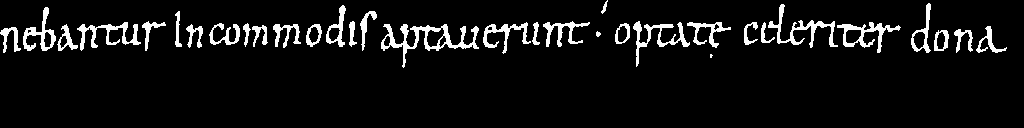

Ground truth: nebantur incommodis aptaverunt optate celeriter dona
Prediction : robancous trecommods ) agreasure : orcelorees Lone 




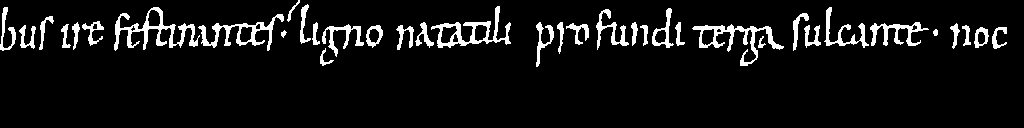

Ground truth: bus ire festinantes ligno natatili profundi terga sulcante noc
Prediction : b181 . Vertenners . " tegono meacts probunds expo , Selecisione : noo 




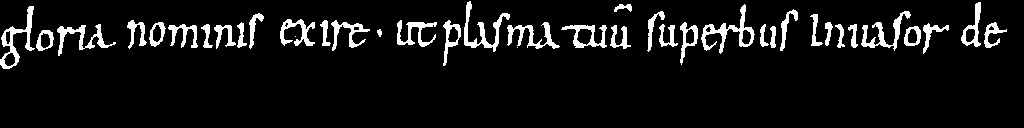

Ground truth: gloria nominis exire ut plasma tuu superbus invasor de
Prediction : orse nomins eviz - succeptme viz - keporkerk & Anned dog do 




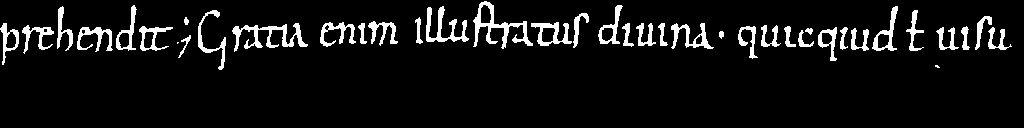

Ground truth: prehendit Gratia enim illustratus divina quicquid l visu
Prediction : rehonde if Gries onnon tiluty deme - equecequed & with 




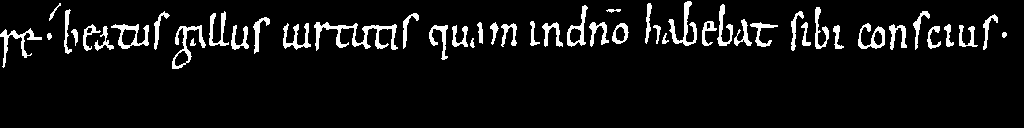

Ground truth: re beatus gallus virtutis quam in dno habebat sibi conscius
Prediction : 18 - beavest Gettles worcest guindine habole the conlences :  




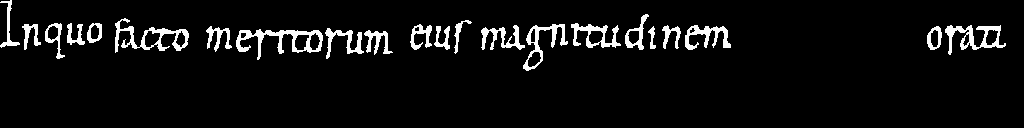

Ground truth: In quo facto meritorum eius magnitudinem orati
Prediction : Engus norresquion ans migneudimen 




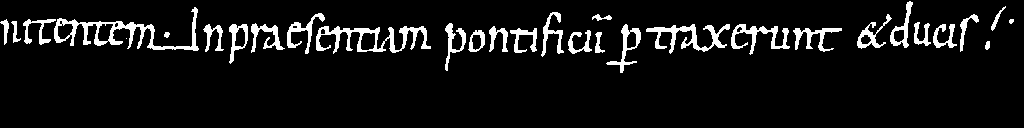

Ground truth: nitentem in praesentiam pontificu ptraxerunt et ducis
Prediction : mencom - Argmenterncon concernoment cernom desticos . )  




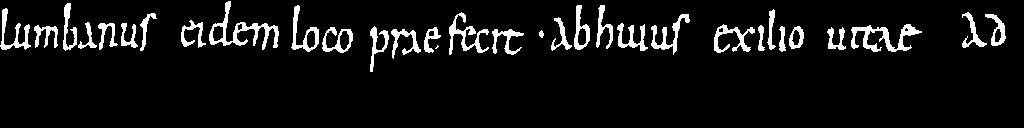

Ground truth: lumbanus eidem loco praefecit ab huius exilio vitae ad
Prediction : tunhions erclem too , moker _ deburs orsho vernoo 




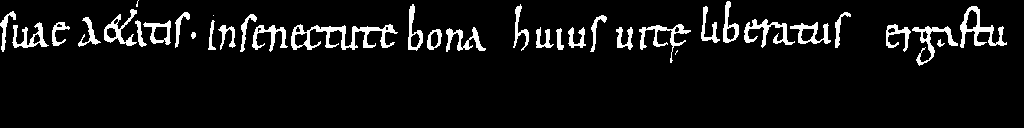

Ground truth: suae aetatis in senectute bona huius vite liberatus ergastu
Prediction : hace - deloor . Bencerne bom haves more tboner oyeitte 




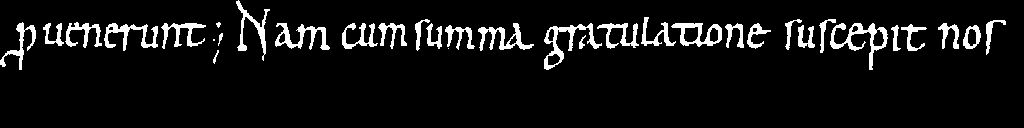

Ground truth: pvenerunt Nam cum summa gratulatione suscepit nos
Prediction : grecornom ; Yam evernmed gructance nocegre not 




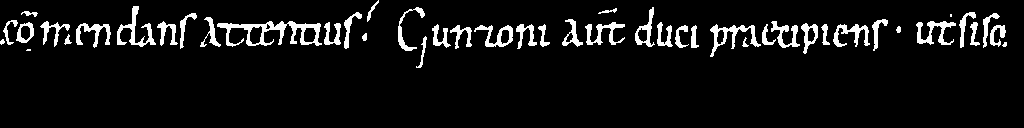

Ground truth: comendans attentius Gunzoni aut duci praecipiens ut si so
Prediction : cimondan1 Necornewet . " Gumon aise duce mcerriors : No 180 .  




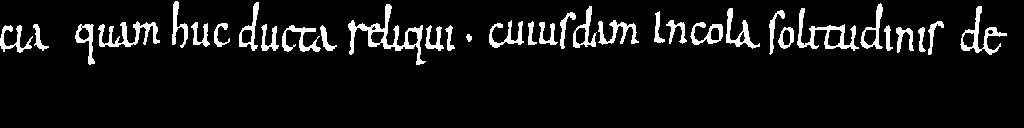

Ground truth: cia quam huc ducta reliqui cuiusdam incola solitudinis de
Prediction : ord guin huse ducres . extoger - exisutetion treed , Colocudings do 




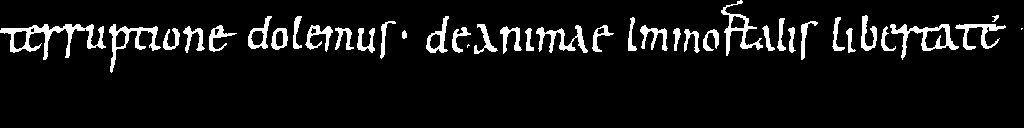

Ground truth: terruptione dolemus de animae immortalis libertate
Prediction : exmmen cotemes : deicmme tonnofiders temoffed 




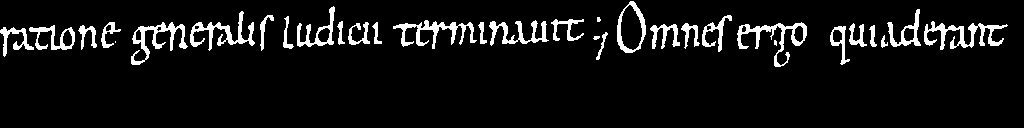

Ground truth: ratione generalis iudicii terminavit Omnes ergo qui aderant
Prediction : mesone genonts tuder exmisure ; Immod arpuden 




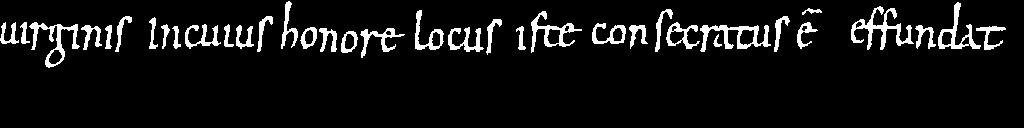

Ground truth: virginis in cuius honore locus iste consecratus e effundat
Prediction : urgonors Srecurs honor tears to conpernacts ( & othunde 




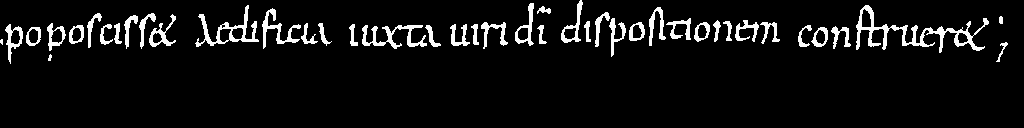

Ground truth: poposcisset aedificia iuxta viri di dispositionem construeret
Prediction : ropolersond Acclashace wered dusporteonm contoromen contorseons ;  




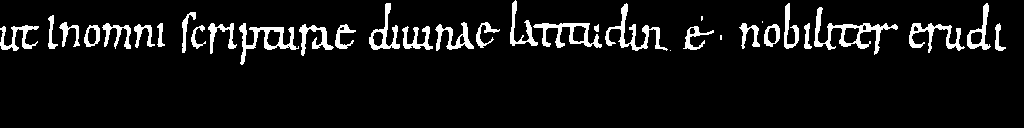

Ground truth: ut in omni scripturae divinae latitudine nobiliter erudi
Prediction :  " trommons Compress ducural tisurater o nobjetrereor ond 




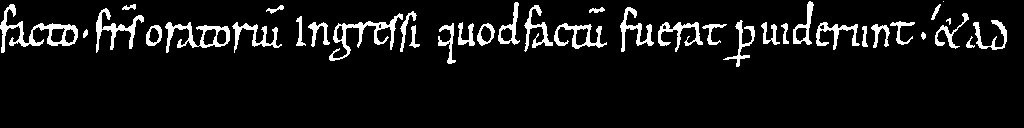

Ground truth: facto frs oratoriu ingressi quod factu fuerat pviderunt et ad
Prediction : hood : bsourses ' s inorrotl quoctared huopse puicdorme - Ad 




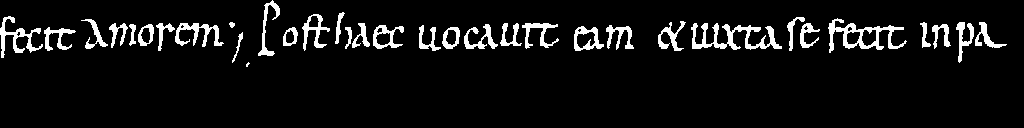

Ground truth: fecit amorem Post haec vocavit eam et iuxta se fecit in pa
Prediction : eve dmorom , ( ot hee were accourse anceas arcuse se . mpon 




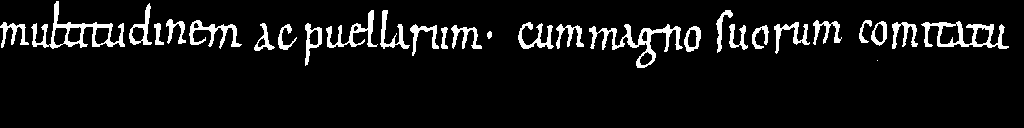

Ground truth: multitudinem ac puellarum cum magno suorum comitatu
Prediction : mutaraudinem acquellym - exmmignonor heopurn commences 




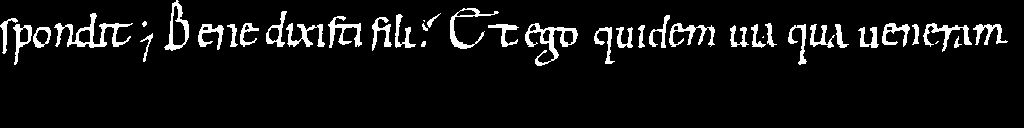

Ground truth: spondit Bene dixisti fili Et ego quidem via qua venram
Prediction : monde , Sene ductis . + Creay quistem ins gues vencomen 




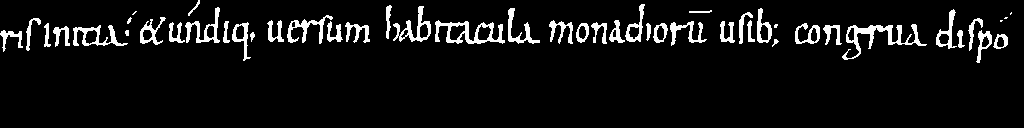

Ground truth: ris initia et undiq versum habitacula monachoru usib congrua dispo
Prediction :  " Pmawideg wortion hibracte moncernte & with , congree dess 




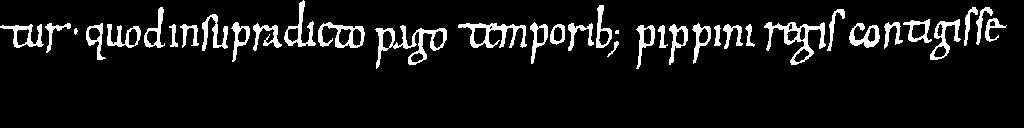

Ground truth: tur quod in supradicto pago temporib pippini regis contigisse
Prediction :  - sur guodintegnationg remprorts , groposart comeghth .  




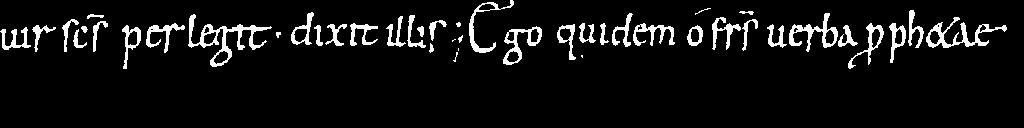

Ground truth: vir scs perlegit dixit illis Ego quidem o frs verba pphetae
Prediction : evised gop togro - ware thos ; b ) Govedem 21801 , 000 plate 




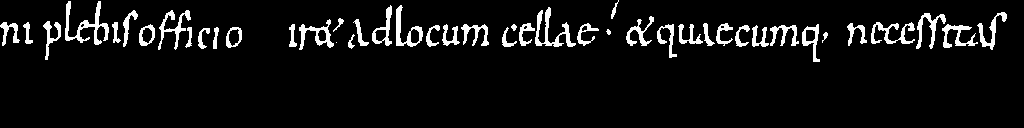

Ground truth: ni plebis officio iret ad locum cellae et quaecumq necessitas
Prediction : mples ) othose Mrd callocours cettace : dequuacecemes nexcortrat 




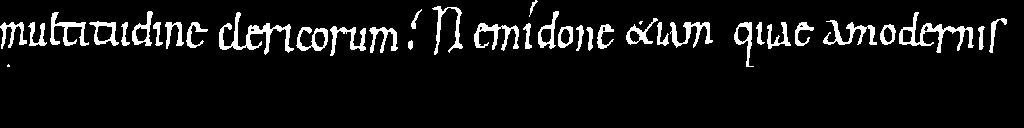

Ground truth: multitudine clericorum Nemidone etiam quae a modernis
Prediction : muterize doscrees . Hemdone courn gue amode amodors 




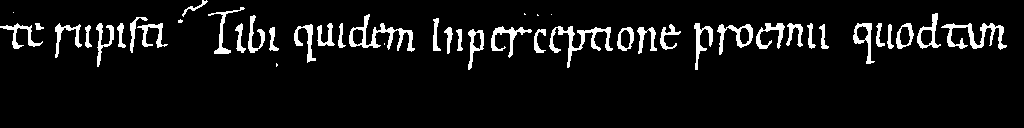

Ground truth: te rupisti Tibi quidem in perceptione proemii quod tam
Prediction : equirpose " Deb giecedion trgrovequence qroms guostacon 




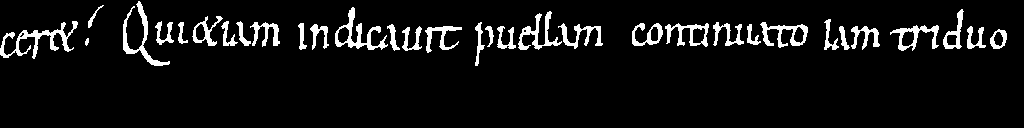

Ground truth: ceret Qui etiam indicavit puellam continuato iam triduo
Prediction : cord . Enuanion indeour quettion comsnue tion exco 




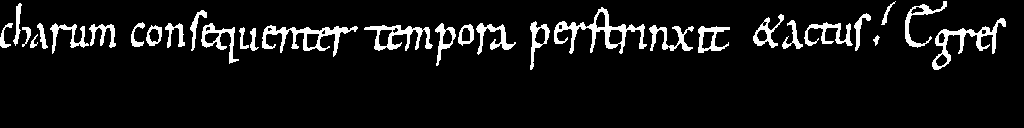

Ground truth: charum consequenter tempora perstrinxit et actus Egres
Prediction : charm constequonor compor zentomen Advers , ( Gov -  




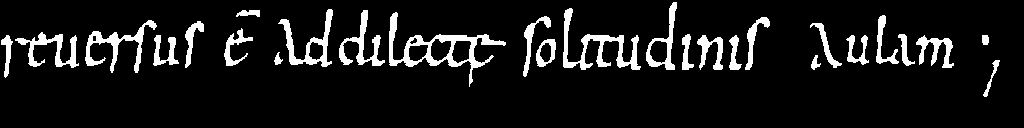

Ground truth: reversus e ad dilecte solitudinis aulam
Prediction : renorter ? dedularg Etawdon Astan :  




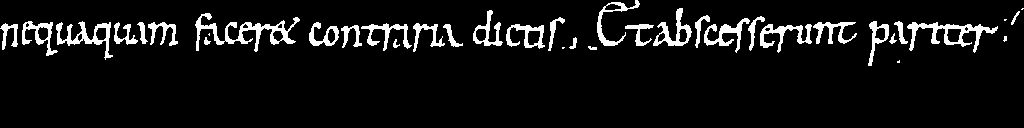

Ground truth: nequaquam faceret contraria dictis Et abscesserunt pariter
Prediction : nequaguion taccorse common Locors , Excabersterm gropreor :  




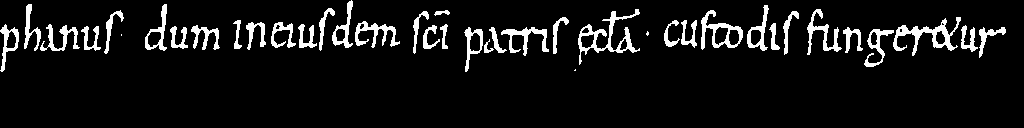

Ground truth: phanus dum in eiusdem sci patris ecla custodis fungeretur
Prediction : shinew dum mensbedem le quors get - ewholds - trods troods -  




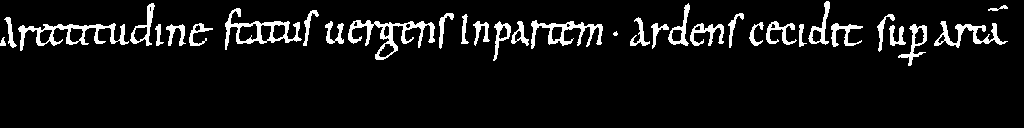

Ground truth: a rectitudine status vergens in partem ardens cecidit sup arca
Prediction : sevence taxt wergor ) Unjurymon : Asccorde hosare 




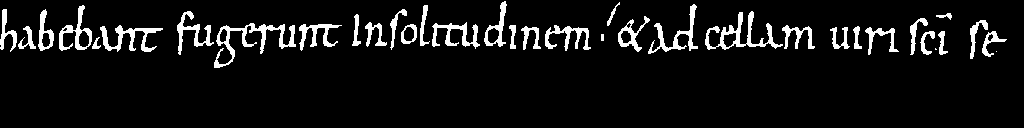

Ground truth: habebant fugerunt in solitudinem et ad cellam viri di se
Prediction : habolave sysme trbetaudmon : ladectlem up & c V .  




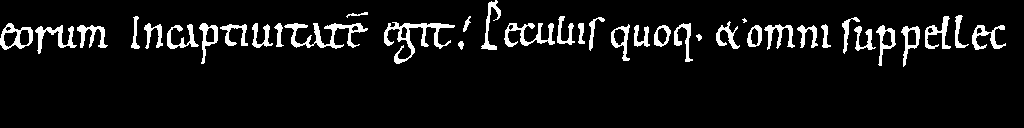

Ground truth: eorum in captivitate egit Peculiis quoq et omni supellec
Prediction : exem tnexquience ogre . Lecuter guory , acomm nuggotlolo 




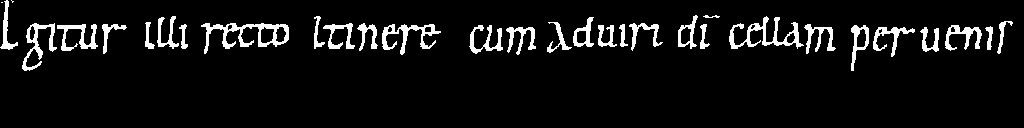

Ground truth: Igitur illi recto itinere cum ad viri di cellam pervenis
Prediction : Grasions All - remore accom decons adetter it collem , grovents 




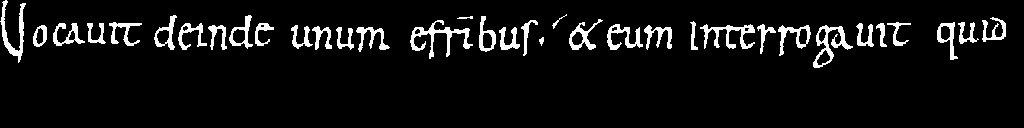

Ground truth: Vocavit deinde unum e fribus et eum interrogavit quid
Prediction : Focaure demin oppos , 2000 , 2 ousum mexprover gus 




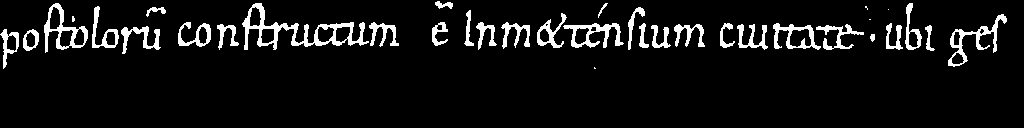

Ground truth: postoloru constructum e in mettensium civitate ubi ges
Prediction : volkstor ' contriceson & trom trom excuse : isbs oot 




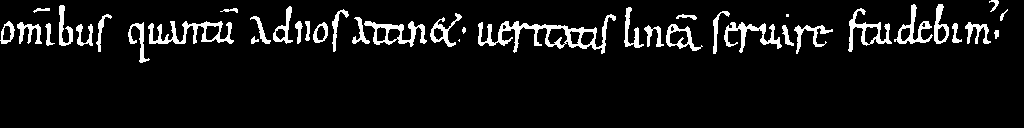

Ground truth: omibus quantu ad nos attinet veritatis linea servare studebim
Prediction : comibes guines ddnot . Necond " nequacts - Lired Coruise tudesbom :  




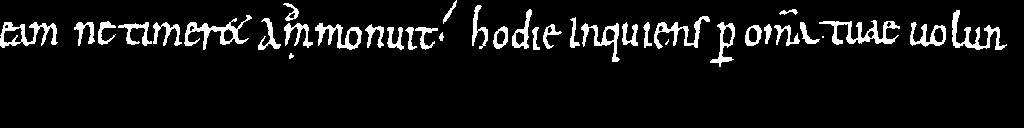

Ground truth: eam ne timeret ammonuit hodie inquiens p oma tuae volun
Prediction : earn nersment dmmonew hoeds trequons Gromi cuse whicor 




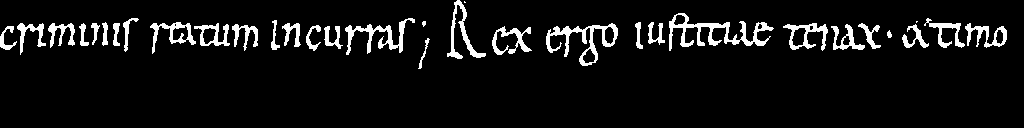

Ground truth: criminis reatum incurras Rex ergo iustitiae tenax et timo
Prediction : ermonors , revernor ; A cc orge entece extecurace exernco 




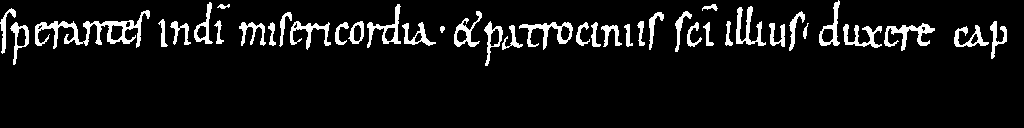

Ground truth: sperantes in di misericordia et patrociniis sci illius duxere cap
Prediction : ponsnes mslerreortes Appercontes _ desittlers . devere cast .  




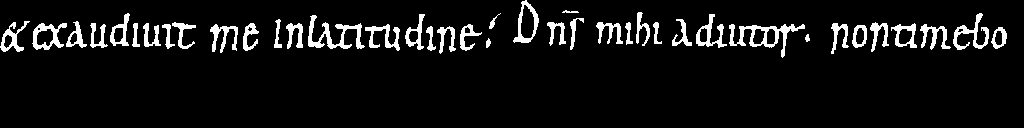

Ground truth: et exaudivit me in latitudine Dns mihi adiutor non timebo
Prediction : ecreandure mo intexcusetione . Ord mke adducors , nomesmabso 




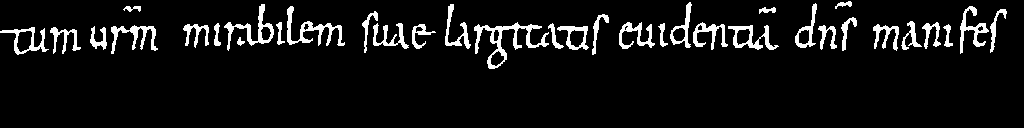

Ground truth: tum vrm mirabilem suae largitatis evidentia dns manifes
Prediction : eumson mischetem , Seargrees ) euncloned And mambet 




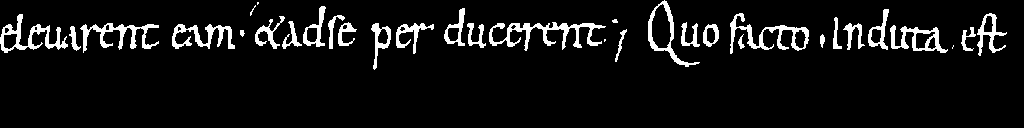

Ground truth: elevarent eam et ad se perducerent Quo facto induta est
Prediction : dousion exr - Addle groor drecern ; Pushaces . tndures th 




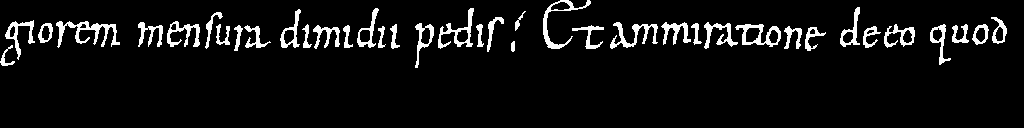

Ground truth: giorem mensura dimidii pedis Et ammiratione de eo quod
Prediction : grom mentine dimiles . ( Excommuncesone does guod 




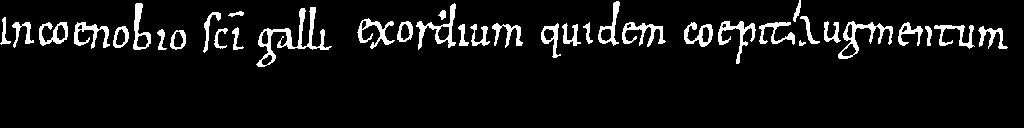

Ground truth: in coenobio sci galli exordium quidem coepit augmentum
Prediction : menobse lee gall occouturn expudem expuntengmon 




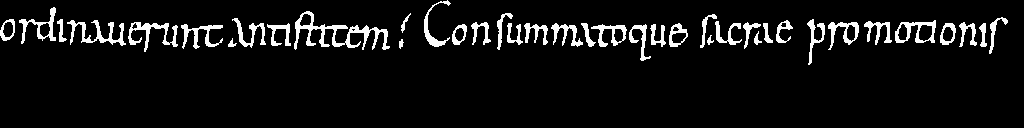

Ground truth: ordinaverunt antistitem Consummatoque sacrae promotionis
Prediction : ordurison - insteceions ( Continmence ) Accouce , yromors 




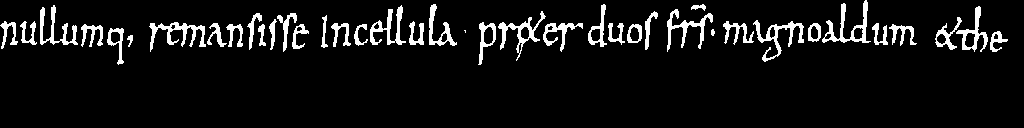

Ground truth: nullumq remansisse in cellula preter duos frs magnoaldum et the
Prediction : mittimong , remankst Veorplor dur , ( 6 ) 5 ( 18 ) ( 15 ) 4 magneatho 




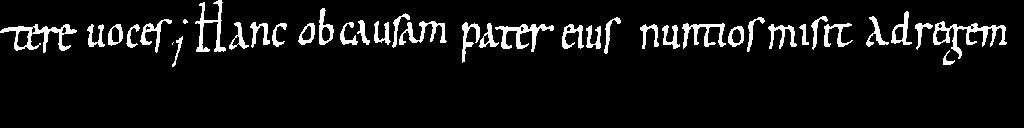

Ground truth: tere voces Hanc ob causam pater eius nuntios misit ad regem
Prediction :  - vere wees , Lane sheamder quexecus ins moste dogem 




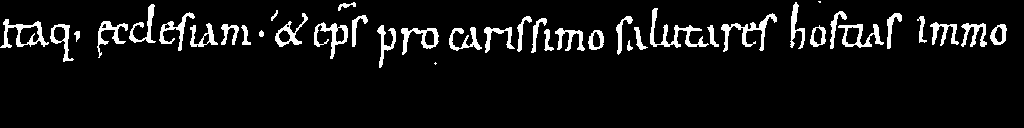

Ground truth: itaq ecclesiam et eps pro carissimo salutares hostias immo
Prediction : ray , grelottion - & coust , 1795 . 152 asttemord hoof hoteal - mmo 




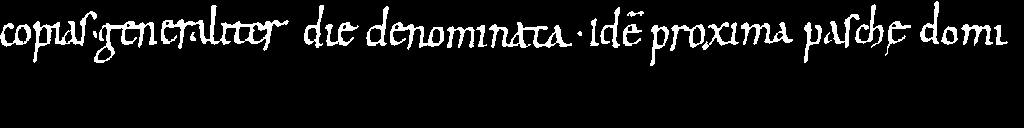

Ground truth: copias generaliter die denominata id e proxima pasche domi
Prediction : corrutaror who donommence - Acte , mmems quolso dom 




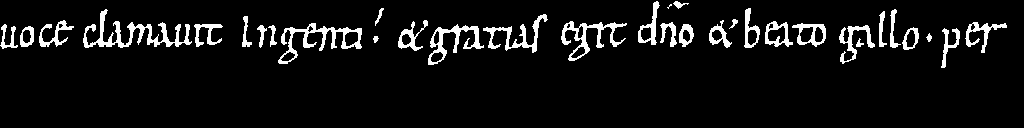

Ground truth: voce clamavit ingenti et gratias egit dno et beato gallo per
Prediction : wee ctamisne tngoms " Agract z And a bauce gittlo , pree 




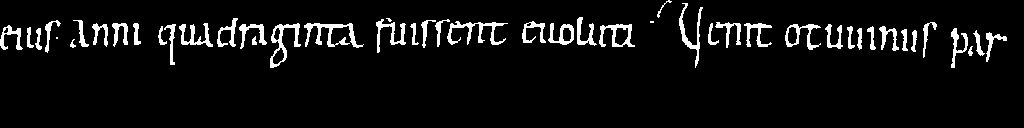

Ground truth: eius anni quadraginta fuissent evoluti Venit otwinus par
Prediction : on1 - amo guetrigned , rusurrer enctived Governments , mor 




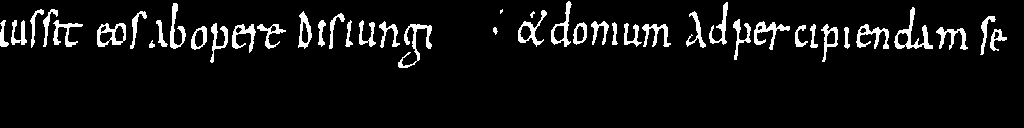

Ground truth: iussit eos ab opere disiungere et domum ad percipiendam se
Prediction :  " the extorcore 21stmor Adommor Adoprequondim , a 




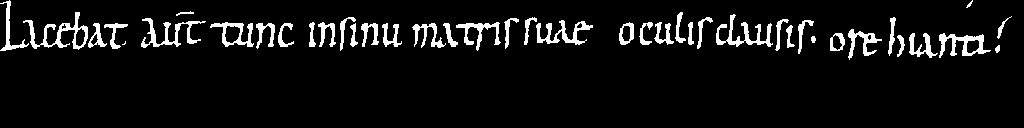

Ground truth: Iacebat aut tunc in sinu matris suae oculis clausis ore hianti
Prediction : Exctur At exxxom Immory , receive executs , on humed 




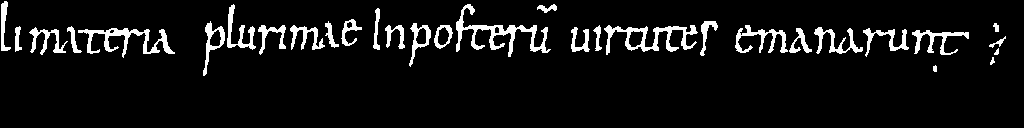

Ground truth: li materia plurimae in posteru virtutes emanarunt
Prediction :  - tement phopme brpokers " iss emanannum :  




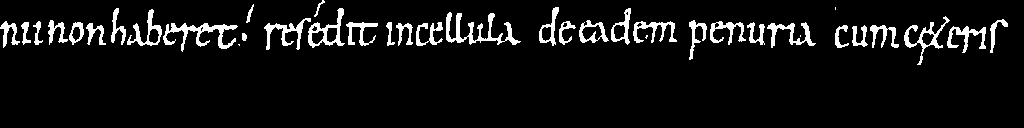

Ground truth: nii non haberet resedit in cellula de eadem penuria cum ceteris
Prediction : mentibor : rebecte mevtllet decardtem qonsions exmestors 




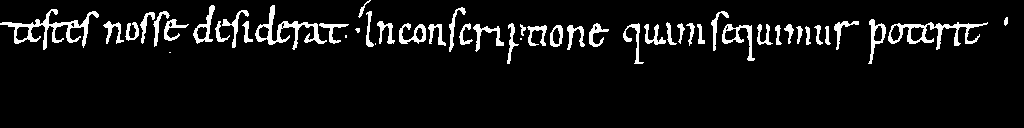

Ground truth: testes nosse desiderat in conscriptione quam sequimur poterit
Prediction :  - steat nothe doudere : Fneconse , Trecone gum , cequire -  




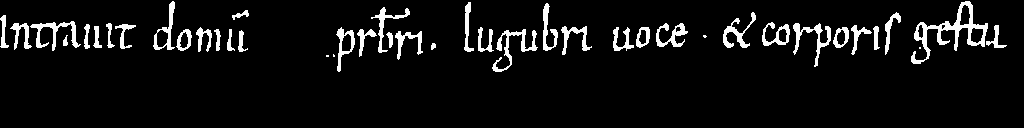

Ground truth: intravit domu prbri lugubri voce et corporis gestu
Prediction : meriune dom - ortiz , troubor wee - A coppos goote 




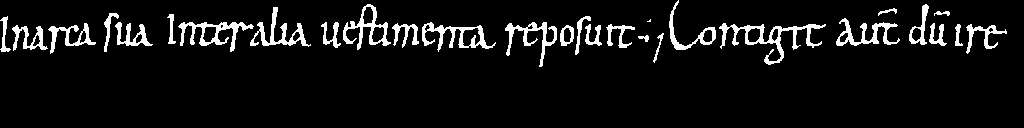

Ground truth: in arca sua inter alia vestimenta reposuit Contigit aut du ire
Prediction : rurse , Ve Wexcrrale veobsemena repoptice : ( conegne ase disone -  




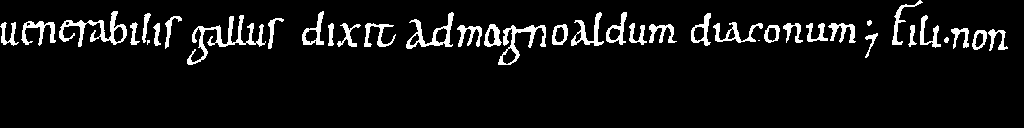

Ground truth: venerabilis gallus dixit ad magnoaldum diaconum Fili non
Prediction : vononombellor ducre admagnoated deconum ; litts mon 




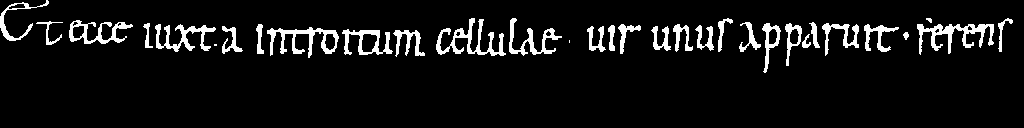

Ground truth: Et ecce iuxta introitum cellulae vir unus apparuit ferens
Prediction : Execuse muserer mbezzerem exttulala 100 unour aggrees , 8000 ,  




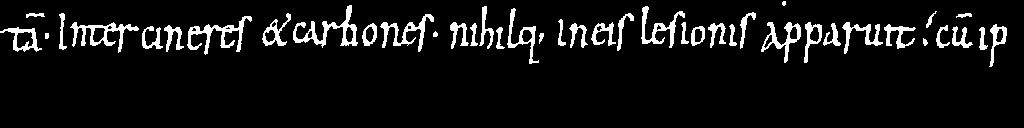

Ground truth: ta inter cineres et carbones nihilq in eis lesionis apparuit cu ip
Prediction : Ad . tresconors deurhonor : _ nehilg , mert lexhont agrupusers . levise 




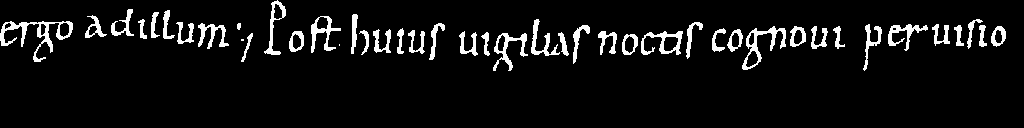

Ground truth: ergo ad illum Post huius vigilias noctis cognovi per visio
Prediction : orge addotlem ; Eold huse , unjoctus , nocers egnourses 




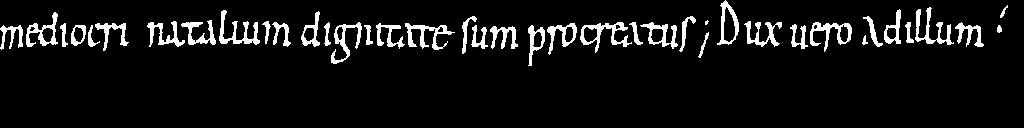

Ground truth: mediocri natalium dignitate sum procreatus Dux vero ad illum
Prediction : mectsor recetiven digminer , pim propersers ; Avernoradittum .  




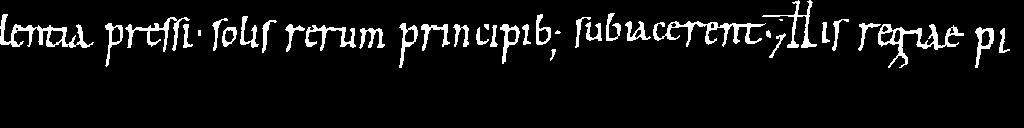

Ground truth: lentia pressi solis rerum princib subiacerent His regiae pi
Prediction : conce Grooth . Bels - reme promess ; rubraccorsern , ll ( 18 ) 10gree on 




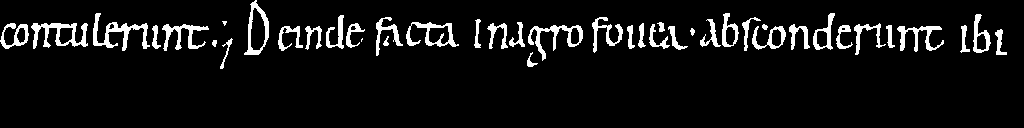

Ground truth: contulerunt Deinde facta in agro fovea absconderunt ibi
Prediction : comestorm if Jeancte pered mughs - Assendem sto 




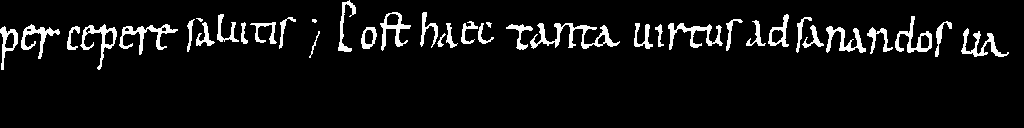

Ground truth: percepere salutis Post haec tanta virtus ad sanandos va
Prediction : regovernor , lon thar exma vimence . decllinumedor 180 .  




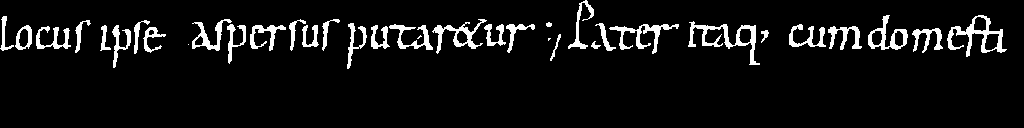

Ground truth: locus ipse aspersus putaretur Pater itaq cum domesti
Prediction : Accous , 1794 apornor grocarr ; larecer Neamdomoted 




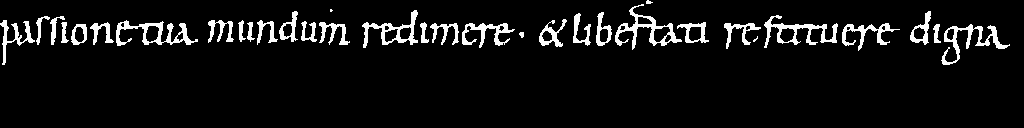

Ground truth: passione tua mundum redimere et libertati restituere digna
Prediction : monororse mundion rectimor . Asbsicace retreceseor degom 




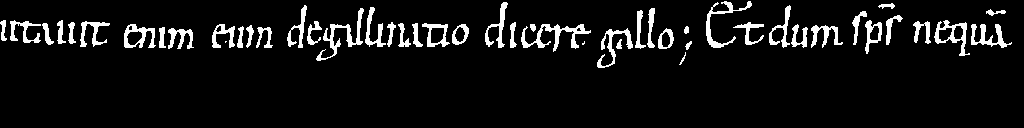

Ground truth: utavit enim eum de gallinatio dicere gallo Et dum sps negua
Prediction : Necure enn amon degettlonares decere gitles , Exectum ( 25 reque 




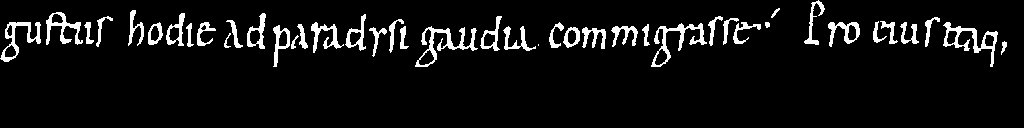

Ground truth: gustiis hodie ad paradysi gaudia commigrasse Pro eius itaq
Prediction : gutars hooke accquinests gaccecte commignmentor Encols ,  




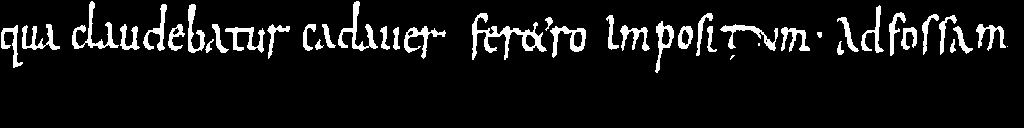

Ground truth: qua claudebatur cadaver feretro impositum ad fossam
Prediction : gue dicudehiars exdurer Coproof tempole m - Adson 




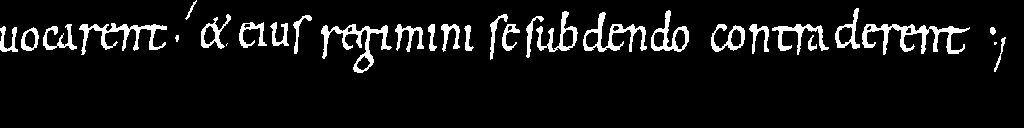

Ground truth: vocarent et eius regimini se subdendo contraderent
Prediction : vocam . A ccous regrmine Colckend common ;  




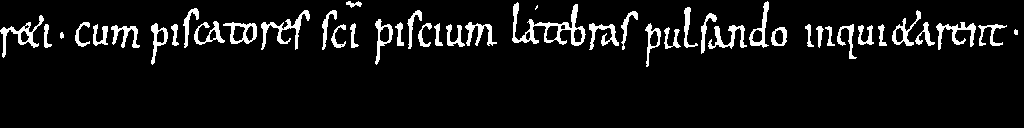

Ground truth: reti cum piscatores sci piscium latebras pulsando inquietarent
Prediction : et : ewn grolarors ( lee grtecurn Lirecbrards mquon :  




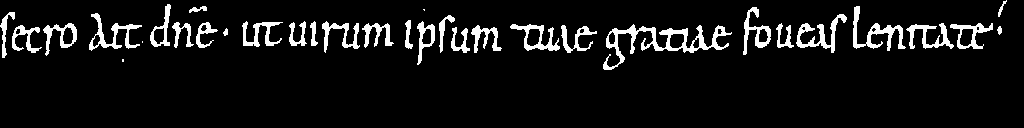

Ground truth: secro ait dne ut virum ipsum tuae gratiae foveas lenitate
Prediction : ever dro - sexcrrim pin excuse gnerace Curcest lennuce .  




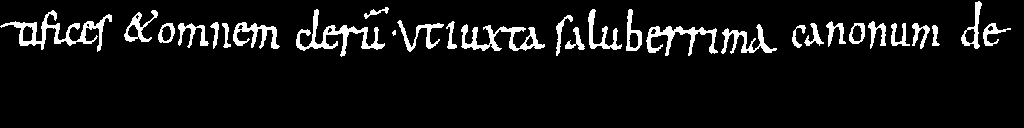

Ground truth: tifices et omnem cleru ut iuxta saluberrima canonum de
Prediction :  - sheer Ammen dopp " recure likeckorns camon de 




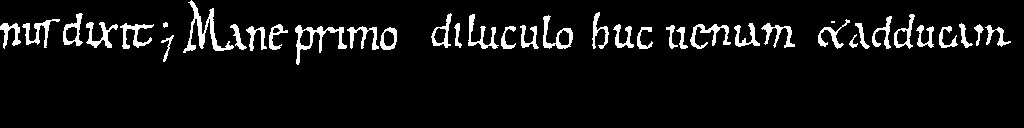

Ground truth: nus dixit Mane primo diluculo huc veniam et adducam
Prediction : more ; Mane gromor deturento hw noncum edestiveam 




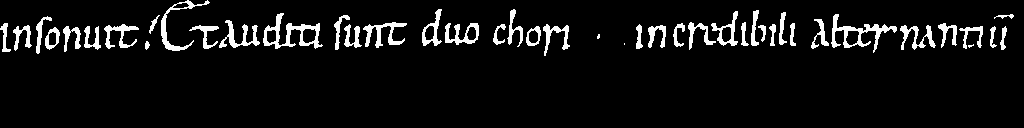

Ground truth: insonuit Et auditi sunt duo chori incredibili alternantiu
Prediction :  ' omonuse . Ceductes him duso - morredible decrminent 




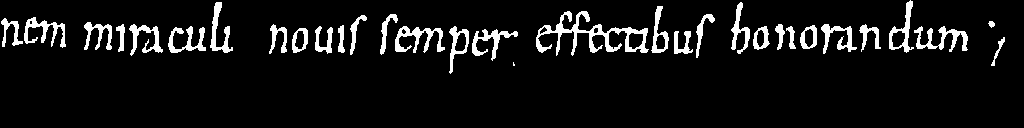

Ground truth: nem miraculi novis semper effectibus honorandum
Prediction : rem meaccel Novers Lemquen obtarchied bonounctur :  




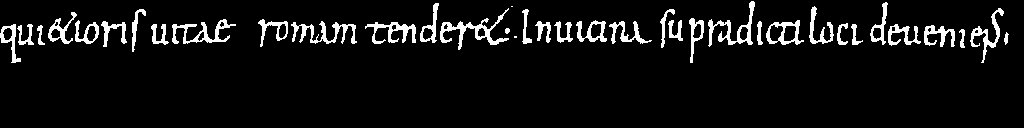

Ground truth: quietioris vitae romam tenderet in vicina supradicti loci deveniens
Prediction : equietors urce romin rendor " Lncurion , Cipmetion - licoccolococonemess 




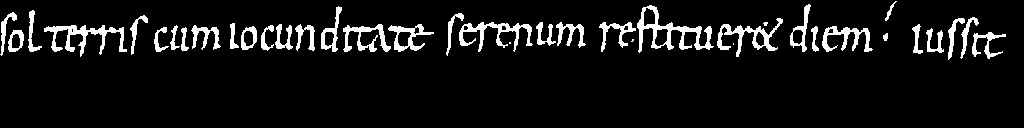

Ground truth: sol terris cum iocunditate serenum restitueret diem iussit
Prediction : A vournors exmecusione , cremum roter com - with 




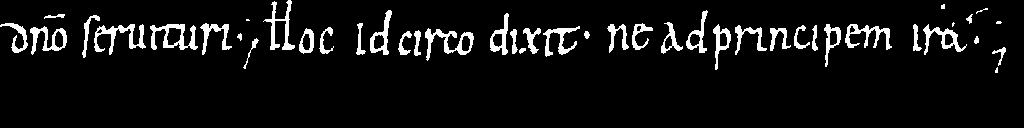

Ground truth: dno servituri Hoc idcirco dixit ne ad principem iret
Prediction : And Lorcers ; Hoo Adors stwer - neadprement Mi !  




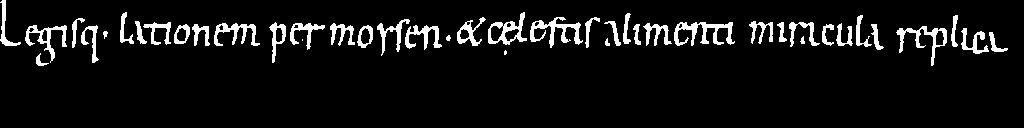

Ground truth: legisq lationem per moysen et celeftis alimenti miracula replica
Prediction : egrtty . Vesom qromorror arctors _ Atiment mechts roghtea 




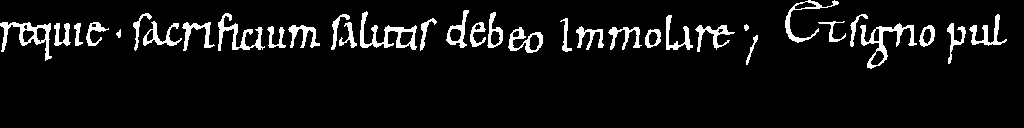

Ground truth: requie sacrificium salutis debeo immolare Et signo pul
Prediction : requence . Accorsteem Accors Asbeer Ammotione ; Gett 




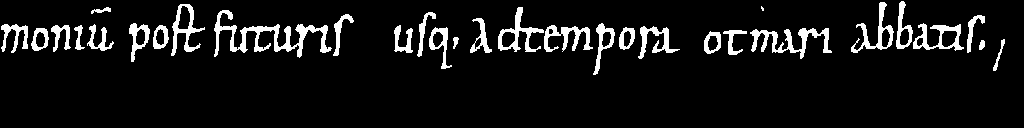

Ground truth: moniu post futuris usq ad tempora otmari abbatis
Prediction : monds _ eoth prevers ss adctemgon oxincer abbacts ,  




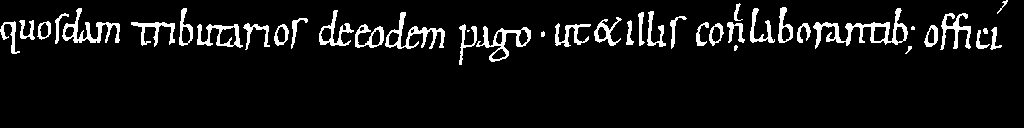

Ground truth: quosdam tributarios de eodem pago ut et illis conlaborantib offici
Prediction : quortion or - Acces . 3cordom maitts explabounces , othee -  




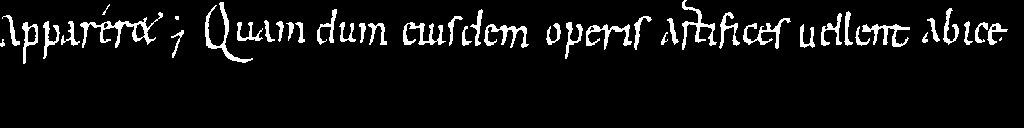

Ground truth: appareret Quam dum eiusdem operis artifices vellent abice
Prediction : yoursore ' s Reun dum eutteon oqers 1 15 . 15theer wotheor absee 




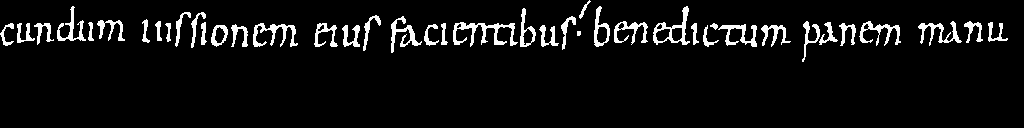

Ground truth: cundum iussionem eius facientibus benedictum panem manu
Prediction : cunducon whomen ens - taccomsbors - benctoreson qunce 




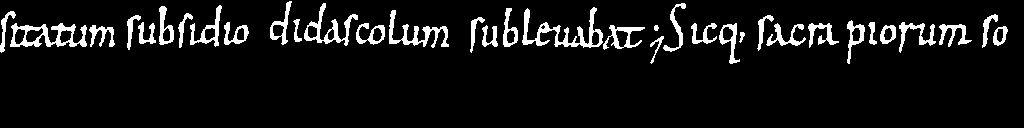

Ground truth: sitatum subsidio didascolum sublevabat sicq sacra piorum so
Prediction : sescision . Subjeste shedalacestion sublouch , ( ree ) acom propm 18 




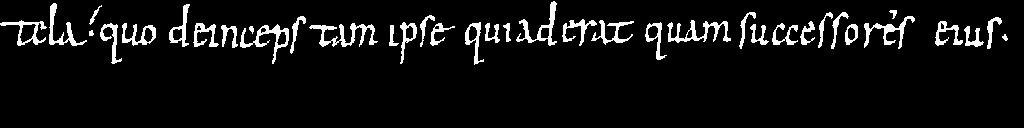

Ground truth: tela quo deinceps tam ipse qui aderat quam successores eius
Prediction : exle - Lexmert " cionjor quadom guan hecest , Cond :  




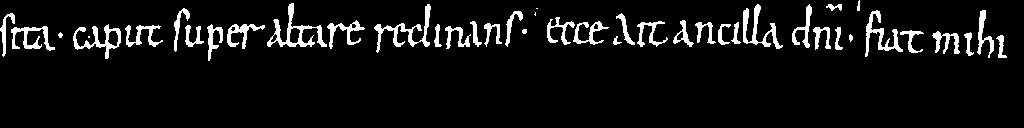

Ground truth: sita caput super altare reclinans ecce ait ancilla dni fiat mihi
Prediction : 1ed capse , knoor itase rectnurs : excee " cosee - Areces mh 




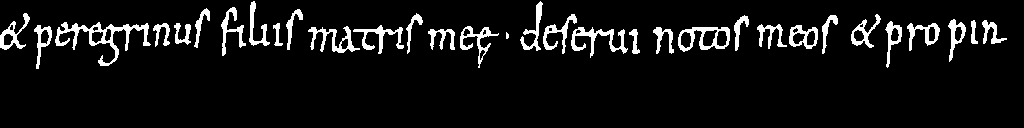

Ground truth: et peregrinus filiis matris mee deserui notos meos et propin
Prediction :  - pencgmes " Clest meass mey - Lebors noxers mast Apropose 




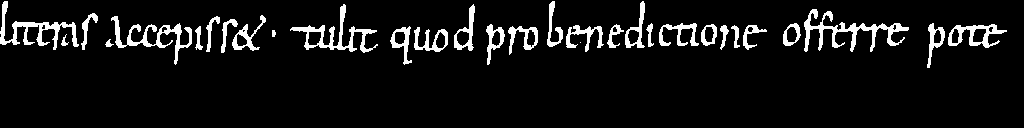

Ground truth: literas accepisset tulit quod pro benedictione offerre pote
Prediction : tecourt Lecomtted : eutse quod probonederecon otherr pose 




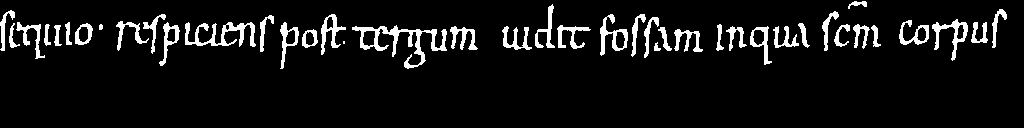

Ground truth: sequio respiciens post tergum vidit fossam in qua scm corpus
Prediction : tryewe - roprevers , ropost exposion ude Deprion mgust Com corpst 




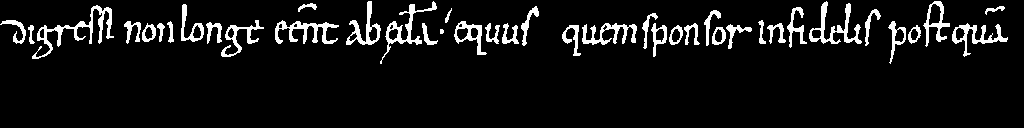

Ground truth: digressi non longe eent ab ecla equus quem sponsor infidelis postqua
Prediction : sogrest nonlongor cire abytk Leguent quent , ponkor idelest postlegue 




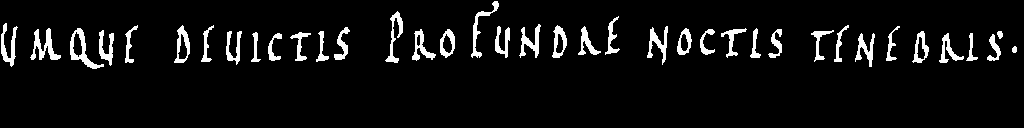

Ground truth: UMQUE DEVICTIS PROFUNDAE NOCTIS TENEBRIS
Prediction : Now Annor Extract 1792 och 21801 .  




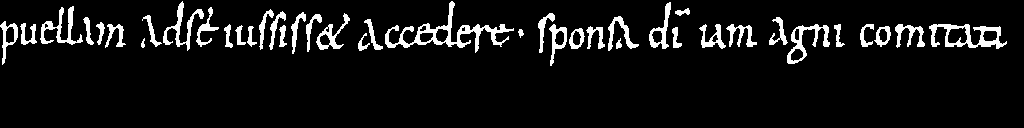

Ground truth: puellam ad se iussisset accedere sponsa di iam agni comitati
Prediction : mellion Adl uthos decedore : poomad do cum dgon coment 




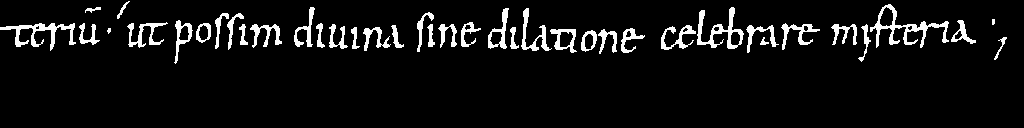

Ground truth: teriu ut possim divina sine dilatione celebrare mysteria
Prediction : everic ! Vorportim dunisne , pono detacione eloborise mptore ;  



In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow
 
for i, item in enumerate(imgs[:100]):
    print("=" * 1024, "\n")
    img = item.permute(1,2,0).cpu().numpy().astype(np.uint8) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    cv2_imshow(pp.adjust_to_see(img))
    print("Ground truth:",gt[i])
    print("Prediction :", predicts[i], "\n")

For the best results I used the ensemble of two checkpoints of model.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11em8U-TpNgQZwLDGR9B5U3cfV859lSaI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11em8U-TpNgQZwLDGR9B5U3cfV859lSaI" -O resnet_second_best.pt && rm -rf /tmp/cookies.txt

In [ ]:
second_model = make_model(100) #I used the vocab size of 100
second_model.load_state_dict(torch.load('resnet_second_best.pt'))
_=second_model.to(device)


In [ ]:
beta = 0.5 #The interpolation parameter    
params1 = model.state_dict()
params2 = second_model.state_dict()
 
dict_params2 = params2
 
for name1, param1 in params1.items():
    if name1 in dict_params2:
        dict_params2[name1].data.copy_(beta*param1.data + (1-beta)*dict_params2[name1].data)
 
model.load_state_dict(dict_params2)

In [ ]:
predicts, gt, imgs = test(model, test_loader, max_text_length)
 
predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [ ]:
evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)


In [ ]:
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))


In [ ]:
l